# 1. Preparação de Dados e Análise Exploratória (EDA)

**Objetivo:** Este notebook é a primeira etapa do nosso fluxo de Machine Learning. Vamos carregar o dataset "longo" que criamos (saída do `create_dataset.py`), limpá-lo, e transformá-lo no formato "largo" (wide) que os modelos de ML precisam.

**Passos:**
1.  **Carregar:** Importar bibliotecas e carregar o `dataset_consolidated_long.csv`.
2.  **Configurar:** Definir nossas variáveis principais (qual coluna prever, como interpolar, etc.).
3.  **Preparar (X e y):** Separar os dados (X) dos rótulos (y).
4.  **Dividir (Split):** Separar os dados em "Treino/Validação" (para experimentos) e "Teste" (nosso "cofre" para avaliação final).
5.  **Transformar (Interpolador):** Usar nossa classe `LongToWideInterpolator` do pacote `pyspecaitoolkit` para transformar os dados "longos" em "largos" e padronizados.
6.  **Explorar (EDA):** Fazer gráficos (Espectros Médios e PCA) nos dados transformados para *ver* se as classes são separáveis.
7.  **Salvar (Checkpoint):** Salvar os dados "largos" e limpos para serem usados no próximo notebook.

In [7]:
# --- 1. Importações de Sistema e Análise ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Para gráficos mais bonitos
import os
import joblib # Para salvar nosso transformador

# --- 2. Importações de Machine Learning (Sklearn) ---
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # Para escalonar dados antes do PCA
from sklearn.decomposition import PCA # Para Análise de Componentes Principais

# --- 3. Importações do NOSSO PACOTE (pyspecaitoolkit) ---
# Importamos a classe "bloco de lego" que criamos no preprocessing.py
from pyspecaitoolkit.preprocessing import LongToWideInterpolator 

# Importamos os nomes de colunas padrão que definimos no protocols_config.py
# Isso evita erros de digitação e mantém a consistência!
from pyspecaitoolkit.protocols.protocols_config import (
    UNIQUE_ID_COL_STD,
    FILENAME_COL_STD,
    SCIENTIFIC_NAME_COL_STD,
    WAVELENGTH_COL_STD,
    INTENSITY_COL_STD,
    LEAF_FACE_COL_STD,
    PROTOCOL_COL_STD,
    SCAN_DATE_COL_STD,
    SCAN_TIME_COL_STD,
    COLLECTOR_COL_STD,
    YEAR_COLLECTED_COL_STD,
    FIELD_NUMBER_COL_STD,
    COUNTRY_COL_STD,
    STATE_COL_STD,
    CITY_COL_STD,
    LOCALITY_COL_STD,
    HABITAT_COL_STD,
    LATITUDE_COL_STD,
    LONGITUDE_COL_STD,
)

# --- 4. Configurações do Notebook ---
# Para os plots aparecerem no notebook
%matplotlib inline 
# Configurações de visualização do Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


# 2. Configuração Inicial (Mínima)

Nesta etapa, definimos **apenas** os arquivos de entrada e saída e as colunas de identificação.

**IMPORTANTE:** Nós *ainda não* definiremos a `TARGET_GRID` (a "régua universal"). Faremos isso na Etapa 4, após explorarmos os dados.

In [17]:
# --- 1. Defina os Caminhos (Relativos à raiz do projeto) ---
# ('..' sobe um nível da pasta 'notebooks/' para a raiz do projeto)
DATASET_PATH = os.path.join("..", "data", "processed", "dataset_consolidated_long.csv")
BASE_OUTPUT_DIR = os.path.join("..", "data", "processed") 
BASE_MODEL_DIR = os.path.join("..", "models")

# --- 2. Defina os Parâmetros do Experimento ---
# 👉 1. Dê um NOME único para este experimento.
EXPERIMENT_NAME = "handroanthus_inpaminicourse_allfaces" # (O usuário edita isso)

# 👉 2. Defina a COLUNA ALVO (Label) que você quer prever.
LABEL_COLUMN = SCIENTIFIC_NAME_COL_STD # (O usuário edita isso)
ID_COLUMN = UNIQUE_ID_COL_STD
PROTOCOL_COLUMN = PROTOCOL_COL_STD # Coluna para verificar o overlap

# --- 3. Defina os Parâmetros de Divisão (Split) ---
TEST_SET_SIZE = 0.20 
RANDOM_STATE = 42

# --- Verificações ---
os.makedirs(OUTPUT_DIR, exist_ok=True) # Garante que a pasta de saída exista
print(f"Dataset de Entrada: {DATASET_PATH}")
print(f"Pasta de Saída: {OUTPUT_DIR}")
print(f"Coluna Alvo (Label): {LABEL_COLUMN}")
print(f"Coluna de ID: {ID_COLUMN}")
print(f"Configuração inicial definida para o experimento: {EXPERIMENT_NAME}")

Dataset de Entrada: ..\data\processed\dataset_consolidated_long.csv
Pasta de Saída: ..\data\processed
Coluna Alvo (Label): scientific_name
Coluna de ID: unique_id
Configuração inicial definida para o experimento: handroanthus_inpaminicourse_allfaces


# 3. Carregar, Filtrar e Preparar X (Dados) e y (Rótulos)

Com nossa configuração definida, esta célula fará o trabalho pesado de preparação dos dados:

1.  **Carregar:** O `dataset_consolidated_long.csv` (o "datacubo" que o `create_dataset.py` gerou) será carregado na memória.
2.  **Filtrar:** O script irá ler o dicionário `FILTERS_TO_APPLY` (da Célula 4) e fatiar o dataset. Se o dicionário estiver vazio, ele usará todos os dados.
3.  **Limpar:** Removerá amostras que não têm um rótulo (label) válido na `LABEL_COLUMN` que definimos.
4.  **Criar `X_long` e `y`:**
    * `X_long`: O DataFrame "longo" (com N*228 linhas) contendo *apenas* os dados filtrados.
    * `y`: A Série "curta" de rótulos (com N linhas), contendo um único rótulo para cada amostra (`unique_id`) nos dados filtrados.

In [9]:
# --- 1. Carregar o Dataset Consolidado ---
print(f"Carregando {DATASET_PATH}...")
try:
    # Usamos low_memory=False para evitar o DtypeWarning
    df_long_COMPLETO = pd.read_csv(DATASET_PATH, low_memory=False) 
    print(f"Dataset completo carregado. Shape: {df_long_COMPLETO.shape}")
except FileNotFoundError:
    print(f"ERRO: Dataset não encontrado em '{DATASET_PATH}'")
    print("Por favor, execute o script 'pyspecaitoolkit.create_dataset' primeiro.")
    raise
except Exception as e:
    print(f"An error occurred loading the CSV: {e}")
    raise

# --- 2. Aplicar Filtros Definidos na Configuração (Célula 4) ---
df_long_filtrado = df_long_COMPLETO.copy() # Começa com todos os dados
if FILTERS_TO_APPLY:
    print("Aplicando filtros definidos pelo usuário...")
    for coluna, valor in FILTERS_TO_APPLY.items():
        try:
            if coluna not in df_long_filtrado.columns:
                 print(f"  AVISO DE FILTRO: A coluna '{coluna}' não foi encontrada no dataset. O filtro será ignorado.")
                 continue
                 
            print(f"  - Filtrando: '{coluna}' == '{valor}'")
            # Salva o número de IDs únicos *antes* de filtrar
            ids_antes = df_long_filtrado[ID_COLUMN].nunique()
            # Aplica o filtro
            df_long_filtrado = df_long_filtrado[df_long_filtrado[coluna] == valor].copy()
            ids_depois = df_long_filtrado[ID_COLUMN].nunique()
            print(f"    > Amostras restantes: {ids_depois} (de {ids_antes})")

        except KeyError:
            # Esta verificação é redundante por causa do 'if' acima, mas é uma boa prática
            print(f"  ERRO DE FILTRO: A coluna '{coluna}' não existe no dataset. O filtro foi ignorado.")
    print(f"Dados filtrados. Shape longo agora: {df_long_filtrado.shape}")
else:
    print("Nenhum filtro personalizado aplicado (usando todos os dados).")

# Limpa o dataframe completo da memória para economizar RAM
del df_long_COMPLETO 

# --- 3. Limpar Rótulos Ausentes (nos dados filtrados) ---
initial_rows = len(df_long_filtrado)
# Remove linhas onde a coluna do rótulo (ex: 'scientific_name') está vazia
df_long_filtrado.dropna(subset=[LABEL_COLUMN], inplace=True)
if len(df_long_filtrado) < initial_rows:
    print(f"Removidas {initial_rows - len(df_long_filtrado)} linhas onde o rótulo '{LABEL_COLUMN}' estava ausente (pós-filtro).")

if df_long_filtrado.empty:
    raise ValueError("Nenhum dado restante após aplicar filtros e remover rótulos ausentes. Verifique seus filtros.")
    
# --- 4. Criar X (Dados) e y (Rótulos) ---
# Todas as etapas seguintes usarão o 'df_long_filtrado'

# 'X_long' são os dados brutos que nossa pipeline de interpolação receberá
X_long = df_long_filtrado.copy() 
del df_long_filtrado # Limpa a última cópia

# 'y' são os rótulos. Precisamos de UMA etiqueta por ID_COLUMN.
# Usamos drop_duplicates() para pegar a primeira etiqueta de cada amostra
# e definimos o ID_COLUMN como o índice (index)
try:
    y = X_long.drop_duplicates(subset=[ID_COLUMN]).set_index(ID_COLUMN)[LABEL_COLUMN]
except KeyError as e:
    print(f"ERRO: A coluna '{e}' (ID_COLUMN ou LABEL_COLUMN) não foi encontrada no seu CSV.")
    print("Verifique seu 'protocols_config.py' e rode 'create_dataset.py' novamente.")
    raise

print(f"\nFormato de X (longo) pronto para split: {X_long.shape}")
print(f"Formato de y (rótulos) pronto para split: {y.shape}")
print(f"\nContagem de classes (rótulos) em 'y' (pós-filtro):\n{y.value_counts()}")

Carregando ..\data\processed\dataset_consolidated_long.csv...
Dataset carregado com sucesso. Shape: (108072, 20)

Formato de X (longo): (108072, 20)
Formato de y (rótulos): (59,)

Contagem de classes (rótulos) em 'y':
scientific_name
Handroanthus barbatus (E.Mey.) Mattos                15
Handroanthus incanus (A.H.Gentry) S.O.Grose          15
Handroanthus serratifolius (A.H.Gentry) S.O.Grose    13
Handroanthus impetiginosus Mattos                     9
Handroanthus ochraceus (Cham.) Mattos                 7
Name: count, dtype: int64


# 4. Dividir (Split) os Dados: O Passo Mais Crítico (Treino vs. "Cofre")

Esta é a etapa mais importante para garantir que nosso modelo seja avaliado de forma honesta e científica. Nosso objetivo é simular o "mundo real".

### O Conceito: A Prova Final (O "Cofre")

Imagine que você está criando um modelo para fazer uma prova.
* **Treinamento Ruim:** Você dá ao modelo 90% das questões da prova para ele "estudar" (decorar) e depois aplica os 10% restantes. O modelo pode tirar 100%, mas ele não *aprendeu* de verdade, ele *decorou*.
* **Treinamento Correto:** Você dá ao modelo um conjunto de **material de estudo** (80% dos nossos dados) e guarda a **prova final** (os 20% restantes) em um **"cofre" (`vault`)**. O modelo *nunca* vê a prova final durante o treinamento.

### O Problema: "Vazamento de Dados" (Data Leakage)

Nosso `X_long` tem 108.072 linhas, mas essas linhas pertencem a apenas 59 amostras. A Amostra `INPA0145168` tem 228 linhas (pontos espectrais) no arquivo.

* **O Erro Fatal:** Se dividíssemos aleatoriamente as 108.072 linhas, poderíamos acidentalmente colocar as 100 primeiras linhas da `INPA0145168` no conjunto de **treino** e as 128 linhas restantes da *mesma amostra* no conjunto de **teste**.
* **A Consequência:** O modelo "vê" a amostra `INPA0145168` durante o treino e depois, ao vê-la no teste, acerta 100% (porque ele já "colou"). Isso nos daria uma acurácia falsamente alta, e o modelo falharia miseravelmente com uma amostra verdadeiramente nova.

### A Solução: Dividir pelo Nível da Amostra (`unique_id`)

A divisão **DEVE** ser feita no nível da amostra. Ou **todas** as 228 linhas da `INPA0145168` vão para o treino, ou **todas** vão para o teste.

A forma mais fácil de fazer isso é usar a Série `y` que criamos na célula anterior. Ela já tem uma linha por amostra (`unique_id`). Nós vamos:
1.  **Dividir o `y` (os 59 rótulos) em dois grupos:**
    * `y_train_val` (ex: 47 rótulos)
    * `y_test` (ex: 12 rótulos - O "Cofre")
2.  **Pegar os IDs** de cada grupo (ex: `train_val_ids` e `test_ids`).
3.  **Usar esses IDs para "fatiar" o `X_long` gigante:**
    * `X_train_val_long`: Todas as 86.000 linhas de espectro cujo `unique_id` está na lista `train_val_ids`.
    * `X_test_long`: Todas as 22.000 linhas de espectro cujo `unique_id` está na lista `test_ids` (O "Cofre").

**O que é `stratify=y`?**
É um parâmetro crucial. Ele garante que a proporção de classes (famílias/espécies) seja a mesma nos conjuntos de treino e teste. Se o seu dataset `y` tem 60% de `H. impetiginosus`, o `stratify` garante que tanto o `y_train_val` quanto o `y_test` também tenham (aproximadamente) 60% de `H. impetiginosus`.

**Resultado:** Teremos 4 variáveis prontas para a próxima etapa (Interpolação):
* `X_train_val_long` / `y_train_val`: Os 80% que usaremos para experimentar e encontrar o melhor modelo (com `GridSearchCV`).
* `X_test_long` / `y_test`: Os 20% do "cofre" que só usaremos no final, para o teste de honestidade.

In [10]:
# --- 4. Dividir (Split) os dados (Treino/Validação vs. Teste) ---
print(f"Dividindo {len(y)} amostras em conjuntos de Treino/Val e Teste...")

# Pega todos os IDs únicos (o índice do nosso 'y')
unique_ids_list = y.index 

# Divide os IDs e os rótulos
train_val_ids, test_ids, y_train_val, y_test = train_test_split(
    unique_ids_list, 
    y, 
    test_size=TEST_SET_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y # Garante que a proporção de classes seja a mesma nos dois conjuntos
)

# Agora, usamos esses IDs para "fatiar" nosso DataFrame longo gigante
X_train_val_long = X_long[X_long[ID_COLUMN].isin(train_val_ids)].copy()
X_test_long = X_long[X_long[ID_COLUMN].isin(test_ids)].copy()

print(f"\nTotal de amostras únicas: {len(unique_ids_list)}")
print(f"  -> Amostras para Treino/Validação: {len(y_train_val)} (Shape longo: {X_train_val_long.shape})")
print(f"  -> Amostras para Teste ('Cofre'): {len(y_test)} (Shape longo: {X_test_long.shape})")

# Limpa a memória (df_long não é mais necessário)
del df_long
del X_long
print("\nVariáveis 'df_long' e 'X_long' originais limpas da memória.")

Dividindo 59 amostras em conjuntos de Treino/Val e Teste...

Total de amostras únicas: 59
  -> Amostras para Treino/Validação: 47 (Shape longo: (86184, 20))
  -> Amostras para Teste ('Cofre'): 12 (Shape longo: (21888, 20))

Variáveis 'df_long' e 'X_long' originais limpas da memória.


# 5. Transformação: "Longo" para "Largo" (Interpolação)

Vamos usar nossa classe customizada `LongToWideInterpolator` (do pacote `pyspecaitoolkit`) para converter nossos DataFrames "longos" (`X_train_val_long`, `X_test_long`) no formato "largo" (wide) que o Scikit-learn espera.

**Processo:**
1.  Criamos uma instância do `LongToWideInterpolator`, passando nossa `TARGET_GRID` (a "régua universal").
2.  **Treinamos (`.fit()`)** o interpolador **APENAS** no conjunto de treino/validação (`X_train_val_long`). É aqui que ele "aprende" o "overlap seguro" (quais colunas/comprimentos de onda remover porque têm `NaN`s) sem "espiar" os dados de teste.
3.  **Transformamos (`.transform()`)** ambos os conjuntos de dados (`X_train_val_long` e `X_test_long`) usando o interpolador já treinado. Isso garante que *exatamente as mesmas colunas* (comprimentos de onda) sejam mantidas em ambos os conjuntos.

In [11]:
print("Iniciando a transformação de Longo para Largo (Interpolação)...")

# 1. Criar o transformador (o "bloco de Lego" do nosso pacote)
#    Usamos os parâmetros que definimos na Célula 4
interpolator = LongToWideInterpolator(
    target_grid=TARGET_GRID,
    id_col=ID_COLUMN,
    wl_col=WAVELENGTH_COL_STD,
    int_col=INTENSITY_COL_STD,
    kind='pchip' # Usando o 'pchip' recomendado para interpolação suave
)

# 2. Treinar (Fit) o Interpolador APENAS nos dados de treino/val (os 80%)
print(f"Treinando o interpolador no conjunto de {X_train_val_long.shape[0]} linhas longas...")
# O .fit() aprende as colunas 'final_columns_' (o overlap seguro)
# Passamos y_train_val por compatibilidade com a API do sklearn
interpolator.fit(X_train_val_long, y_train_val) 

# 3. Transformar ambos os conjuntos de dados
print("Transformando dados de treino/val...")
X_train_val_wide = interpolator.transform(X_train_val_long)

print("Transformando dados de teste ('cofre')...")
X_test_wide = interpolator.transform(X_test_long)

# 4. Verificar os novos shapes
print("\n--- Transformação Concluída ---")
print(f"Shape de X_train_val_wide (Pronto para ML): {X_train_val_wide.shape}")
print(f"Shape de y_train_val (Rótulos): {y_train_val.shape}")
print(f"\nShape de X_test_wide (Pronto para ML): {X_test_wide.shape}")
print(f"Shape de y_test (Rótulos): {y_test.shape}")

# Verificação final: X e y têm o mesmo número de amostras (linhas)
# Esta é a verificação que falhou no nosso teste anterior e agora deve passar
assert X_train_val_wide.shape[0] == y_train_val.shape[0]
assert X_test_wide.shape[0] == y_test.shape[0]
# E verifica se ambos os conjuntos 'wide' têm o mesmo número de colunas (features)
assert X_train_val_wide.shape[1] == X_test_wide.shape[1]

print("\n✅ Verificação de shape passou! X e y estão alinhados e prontos para o GridSearchCV.")
print(f"   Número final de features (comprimentos de onda): {X_train_val_wide.shape[1]}")

Iniciando a transformação de Longo para Largo (Interpolação)...
Treinando o interpolador no conjunto de 86184 linhas longas...
Interpolator (fit): Learning valid wavelength overlap...
  Interpolator (fit): All target grid wavelengths are valid (no NaNs found).
Transformando dados de treino/val...
Transformando dados de teste ('cofre')...

--- Transformação Concluída ---
Shape de X_train_val_wide (Pronto para ML): (47, 351)
Shape de y_train_val (Rótulos): (47,)

Shape de X_test_wide (Pronto para ML): (12, 351)
Shape de y_test (Rótulos): (12,)

✅ Verificação de shape passou! X e y estão alinhados e prontos para o GridSearchCV.
   Número final de features (comprimentos de onda): 351


# 6. Análise Exploratória (EDA) nos Dados Transformados

Agora que temos nossos dados "largos" e limpos (`X_train_val_wide`), podemos fazer o PCA e os plots de espectro médio que queríamos.

Gerando Plot 1: Análise de Componentes Principais (PCA)...
  - Calculando PCA (n_components=2)...
  - Plotando PC1 vs PC2...


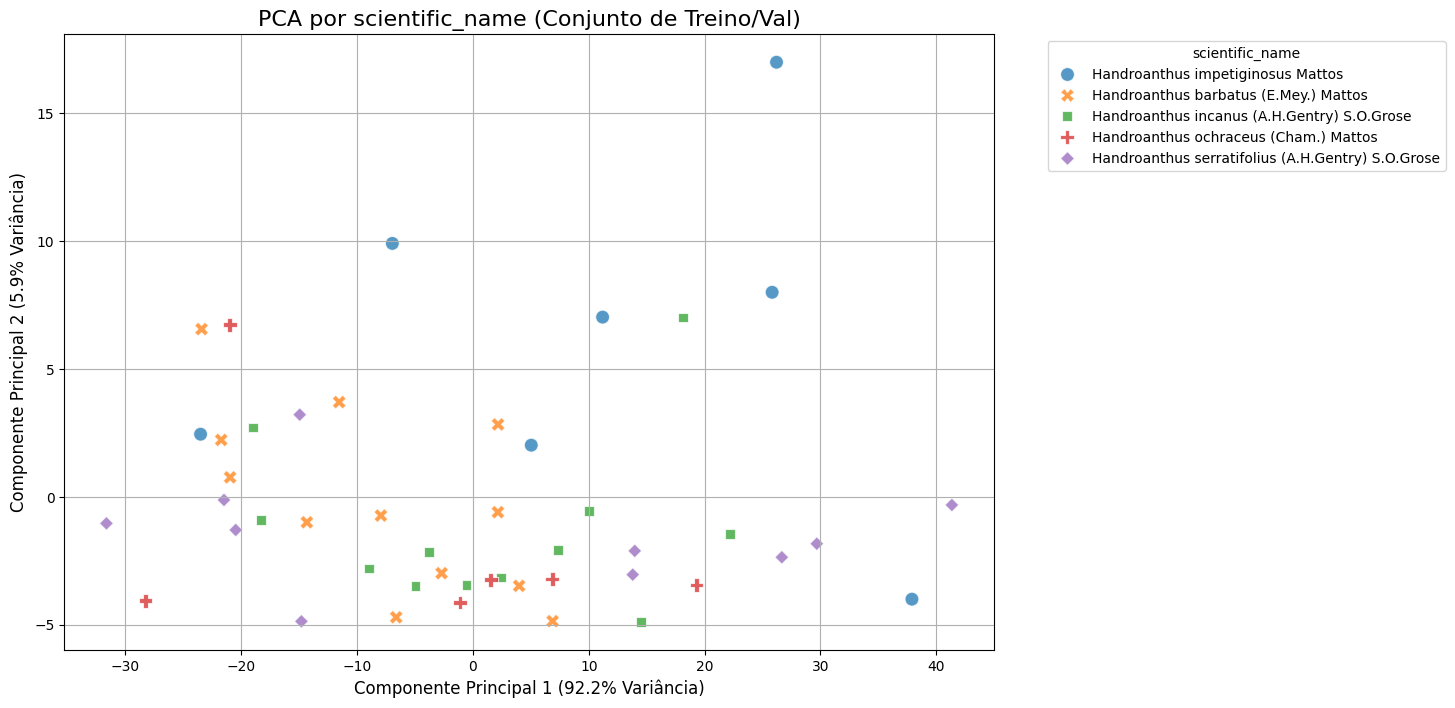


Gerando Plot 2: Espectros Médios (Pós-Interpolação)...


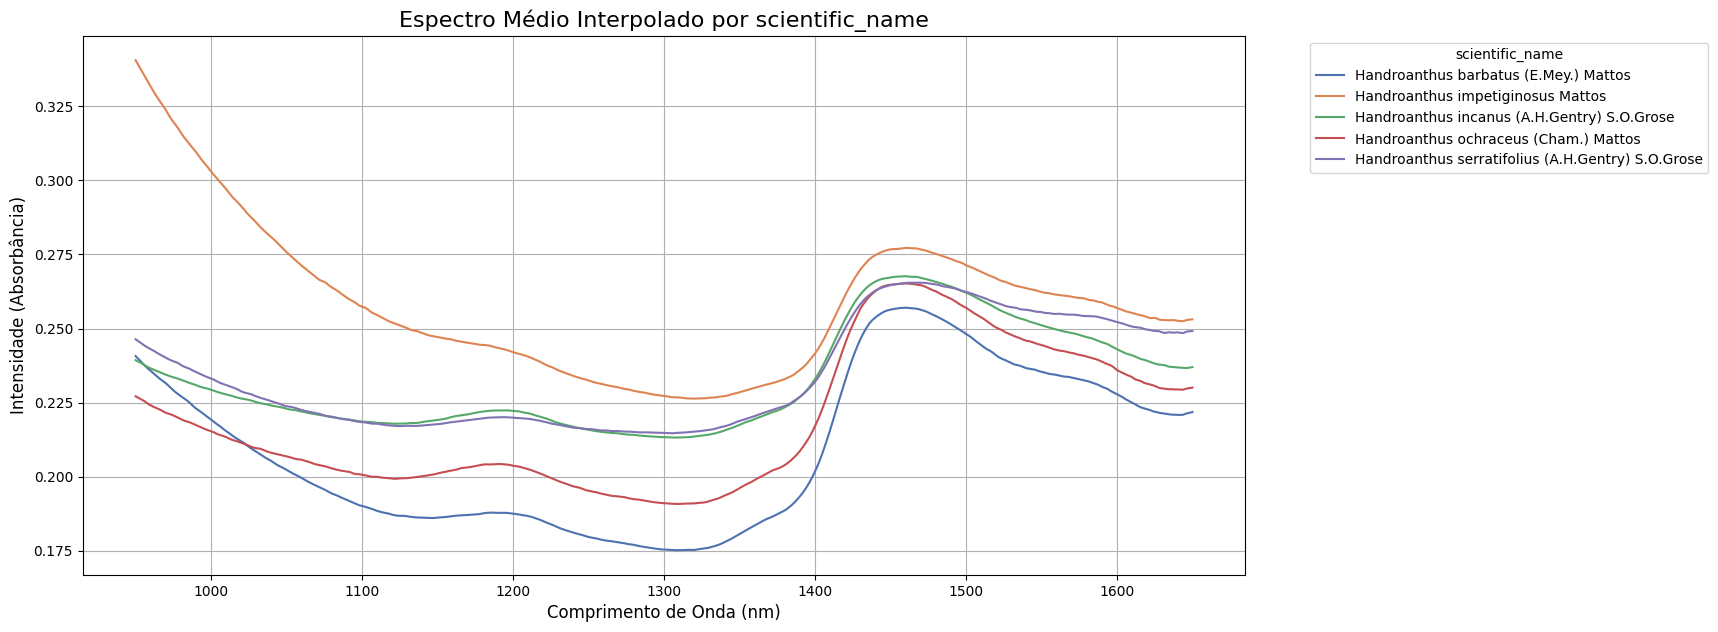


--- Análise Exploratória (EDA) concluída ---


In [12]:
# (Este código é o mesmo da Célula 8 do plano anterior)

# --- 1. Plotar PCA (Análise de Componentes Principais) ---
print("Gerando Plot 1: Análise de Componentes Principais (PCA)...")

# PCA funciona melhor com dados escalonados
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val_wide)

print("  - Calculando PCA (n_components=2)...")
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_train_val_scaled) # Reduz para 2 dimensões

# Vamos colocar os resultados do PCA em um DataFrame para facilitar o plot
df_pca = pd.DataFrame(
    data=X_pca, 
    columns=['PC1', 'PC2'], 
    index=X_train_val_wide.index # Preserva o ID_COLUMN (unique_id)
)
# Junta os rótulos (labels) de volta
df_pca_with_labels = df_pca.join(y_train_val)

print("  - Plotando PC1 vs PC2...")
plt.figure(figsize=(12, 8))
variance_explained = pca.explained_variance_ratio_ * 100

ax_pca = sns.scatterplot(
    data=df_pca_with_labels,
    x='PC1',
    y='PC2',
    hue=LABEL_COLUMN, # Colorir os pontos pelo rótulo
    style=LABEL_COLUMN, # Mudar o formato do ponto pelo rótulo
    s=100, # Tamanho do ponto
    alpha=0.75
)
ax_pca.set_title(f"PCA por {LABEL_COLUMN} (Conjunto de Treino/Val)", fontsize=16)
ax_pca.set_xlabel(f"Componente Principal 1 ({variance_explained[0]:.1f}% Variância)", fontsize=12)
ax_pca.set_ylabel(f"Componente Principal 2 ({variance_explained[1]:.1f}% Variância)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=LABEL_COLUMN)
plt.grid(True)
plt.show()

# --- 2. Plotar Espectros Médios ---
print("\nGerando Plot 2: Espectros Médios (Pós-Interpolação)...")
try:
    # (Usando X_train_val_wide_with_labels que já criamos para o PCA)
    df_mean_spectra = X_train_val_wide.join(y_train_val).groupby(LABEL_COLUMN).mean()

    plt.figure(figsize=(15, 7))
    ax_mean = sns.lineplot(
        data=df_mean_spectra.transpose(), 
        dashes=False,
        palette="deep" 
    )
    ax_mean.set_title(f"Espectro Médio Interpolado por {LABEL_COLUMN}", fontsize=16)
    ax_mean.set_xlabel("Comprimento de Onda (nm)", fontsize=12)
    ax_mean.set_ylabel("Intensidade (Absorbância)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=LABEL_COLUMN)
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Não foi possível plotar os espectros médios. Erro: {e}")

print("\n--- Análise Exploratória (EDA) concluída ---")

# 7. Salvar Dados (Checkpoint)

Ótimo! Nossos dados de treino (`X_train_val_wide`, `y_train_val`) e teste (`X_test_wide`, `y_test`) estão limpos, no formato "wide" correto, e os plots de EDA parecem promissores.

Vamos salvar esses arquivos processados em disco. O próximo notebook (`2_Model_Experimentation.ipynb`) irá carregar estes arquivos para focar *apenas* no `GridSearchCV` e na experimentação de modelos. Também salvaremos o `interpolator` treinado, pois ele será necessário para a pipeline de produção.

In [14]:
print("Salvando arquivos de checkpoint para o Notebook 2...")

# Definir caminhos de saída (usando variáveis da Célula 4)
X_TRAIN_VAL_WIDE_PATH = os.path.join(OUTPUT_DIR, "X_train_val_wide.csv")
Y_TRAIN_VAL_PATH = os.path.join(OUTPUT_DIR, "y_train_val.csv")
X_TEST_WIDE_PATH = os.path.join(OUTPUT_DIR, "X_test_wide.csv")
Y_TEST_PATH = os.path.join(OUTPUT_DIR, "y_test.csv")
INTERPOLATOR_PATH = os.path.join(MODEL_OUTPUT_DIR, "1_interpolator.pkl") # Salva na pasta de modelos

try:
    # Salvar dados "wide" (o índice é o ID_COLUMN, o que é bom)
    X_train_val_wide.to_csv(X_TRAIN_VAL_WIDE_PATH)
    X_test_wide.to_csv(X_TEST_WIDE_PATH)
    
    # Salvar rótulos
    y_train_val.to_csv(Y_TRAIN_VAL_PATH, header=True) # Salva como CSV com cabeçalho
    y_test.to_csv(Y_TEST_PATH, header=True)
    
    # Salvar o interpolator TREINADO
    joblib.dump(interpolator, INTERPOLATOR_PATH)
    
    print("\n✅ Arquivos de checkpoint salvos com sucesso:")
    print(f"  - {X_TRAIN_VAL_WIDE_PATH}")
    print(f"  - {Y_TRAIN_VAL_PATH}")
    print(f"  - {X_TEST_WIDE_PATH}")
    print(f"  - {Y_TEST_PATH}")
    print(f"  - {INTERPOLATOR_PATH}")
    
    print("\nFINISH")

except Exception as e:
    print(f"\n❌ ERRO ao salvar arquivos de checkpoint: {e}")
    import traceback
    traceback.print_exc()

Salvando arquivos de checkpoint para o Notebook 2...

✅ Arquivos de checkpoint salvos com sucesso:
  - ..\data\processed\X_train_val_wide.csv
  - ..\data\processed\y_train_val.csv
  - ..\data\processed\X_test_wide.csv
  - ..\data\processed\y_test.csv
  - ..\models\inpa_minicourse_v1\1_interpolator.pkl

FINISH


# 7. Conclusão (Notebook 1) e Arquivos Salvos

Parabéns! Concluímos a Fase 1: Preparação e Análise Exploratória dos Dados.

### O que Realizamos Neste Notebook?

1.  **Carregamos** o `dataset_consolidated_long.csv` (com 100.000+ linhas).
2.  **Preparamos `X` e `y`:** Separamos os dados brutos (`X_long`) dos rótulos (`y`, com 59 amostras únicas).
3.  **Dividimos os Dados (Split):** Criamos nossos conjuntos de "Treino/Validação" (80% das amostras) e "Teste/Cofre" (20%) de forma segura, garantindo que todas as leituras de uma mesma amostra ficassem juntas.
4.  **Transformamos (A Mágica):** Usamos nosso transformador customizado `LongToWideInterpolator` (do pacote `pyspecaitoolkit`) para:
    * **Aprender (`.fit`)** a faixa de sobreposição (overlap) segura dos comprimentos de onda *apenas* nos dados de treino .
    * **Transformar (`.transform`)** os dados longos em matrizes "largas" (wide), limpas e padronizadas (ex: `(47, 351)`), prontas para o ML.
5.  **Exploramos (EDA):** Confirmamos visualmente (com os plots de Espectro Médio e PCA) que nossas classes (espécies) são, de fato, separáveis.

Isso resolveu nosso principal desafio técnico: o `ValueError` de *samples inconsistent*. Agora, todos os nossos conjuntos de dados `X` (largos) e `y` (rótulos) estão perfeitamente alinhados.

### Arquivos Gerados (Checkpoints)

Esta etapa salvou os seguintes arquivos nas pastas `data/processed/` e `models/`. Estes arquivos são os **pontos de partida** para o próximo notebook:

* **`data/processed/X_train_val_wide.csv`:** A matriz de features (dados espectrais "largos", ex: 47 amostras) que usaremos para experimentar e treinar nossos modelos.
* **`data/processed/y_train_val.csv`:** Os rótulos (labels, ex: 47 rótulos) correspondentes ao arquivo acima.
* **`data/processed/X_test_wide.csv`:** A matriz de features do nosso "cofre" (ex: 12 amostras).
* **`data/processed/y_test.csv`:** Os rótulos do "cofre".
* **`models/1_interpolator.pkl`:** Este é um arquivo de modelo **crucial**. É o nosso `LongToWideInterpolator` *treinado* (ele "sabe" qual é a grade alvo e quais colunas de overlap manter). Precisaremos dele na **Etapa 3** (Exportação Final) e no nosso **Motor de Inferência** para processar dados novos.

---

### Próximo Passo

Estamos prontos para a parte divertida: **encontrar o melhor modelo**.

**Abra o próximo notebook: `2_Model_Experimentation.ipynb`**

Nesse notebook, vamos:
1.  Carregar os arquivos `..._wide.csv` que acabamos de salvar.
2.  Definir um "cardápio" (`param_grid`) de diferentes pipelines de pré-processamento (SNV, Savitzky-Golay) e modelos (RandomForest, SVC).
3.  Usar o `GridSearchCV` para testar todas as combinações e encontrar a "receita" vencedora.